In [1]:
#pemrosesan Dataframe
import pandas as pd

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

#validasi dan tuning
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split,GridSearchCV

# Model
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import lightgbm as lgb

#Tingkat kepentingan fitur
import eli5
from eli5.sklearn import PermutationImportance

#fungsi di matematika
import numpy as np
from math import sqrt

#metrik evaluasi
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

## Membaca dataset

In [2]:
train=pd.read_csv("../data/Bike Sharing Demand/train.csv")
test=pd.read_csv("../data/Bike Sharing Demand/test.csv")

# Eksplorasi Data dan Analisis

In [3]:
train.shape

(10886, 13)

In [4]:
test.shape

(6493, 10)

Data train memiliki 13 kolom, sedangkan data test memiliki 10 kolom. Hal ini merupakan sesuatu yang sedikit ganjil. Sehingga perlu ditelusuri apa saja kolom yang ada di data train namun tidak ada di data test

In [5]:
train.columns

Index(['datetime', 'season', 'holiday', 'weekday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'cnt'],
      dtype='object')

In [6]:
test.columns

Index(['datetime', 'season', 'holiday', 'weekday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed'],
      dtype='object')

Tiga fitur yang tredapat di data train namun tidak ada di data test yaitu registered, casual, dan juga cnt. Seharunya hanya ada satu fitur yang tidak ada di data test yaitu fitur yang akan diprediksi yaitu fitur cnt. Oleh karena itu, keberadaan fitur casual dan registered perlu ditelusuri lebih lanjut dengan melihat hubungan antara fitur casual, registered, dan cnt. 

In [7]:
ftr=['registered','casual','cnt']

In [8]:
train[ftr].head(10)

registered  casual  cnt
0          13       3   16
1          32       8   40
2          27       5   32
3          10       3   13
4           1       0    1
5           1       0    1
6           0       2    2
7           2       1    3
8           7       1    8
9           6       8   14

In [9]:
train[ftr].mean()

registered    155.552177
casual         36.021955
cnt           191.574132
dtype: float64

Berdasarkan data diatas dapat diketahui fakta bahwa hubungan antara casual, registered dan cnt sebagai berikut:

casual + registered = cnt

In [10]:
#Penggabungan data train dan data test untuk mempermudah proses cleansing. 
#Karena biasanya hal yang dilakukan di train juga dilakukan di test. Contoh : drop kolom, dan menambahka kolom
data=train.append(test)

D:\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


# Data Cleansing

### Melihat keseragaman dari setiap fitur

In [11]:
data.nunique()

atemp            65
casual          309
cnt             822
datetime      17379
holiday           2
humidity         89
registered      731
season            4
temp             50
weather           4
weekday           7
windspeed        30
workingday        2
dtype: int64

Berdasarkan data diatas dapat dilihat bahwa tidak ada kolom yang hanya berisi satu nilai yang unik, sehingga tidak perlu menghapus kolom pada dataset

### Memeriksa Apakah terdapat fitur yang memiliki null values

In [12]:
data.isnull().sum()

atemp            0
casual        6493
cnt           6493
datetime         0
holiday          0
humidity         0
registered    6493
season           0
temp             0
weather          0
weekday          0
windspeed        0
workingday       0
dtype: int64

In [13]:
test.isnull().sum()

datetime      0
season        0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [14]:
train.isnull().sum()

datetime      0
season        0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

fitur yang memiliki missing value hanya di casual, registered, dan cnt tepatnya di data yang berasal dari data test. 
Sehingga tidak diperlukan penggisian missing value di data train maupun data test



### Memeriksa korelasi antar fitur dengan heatmap

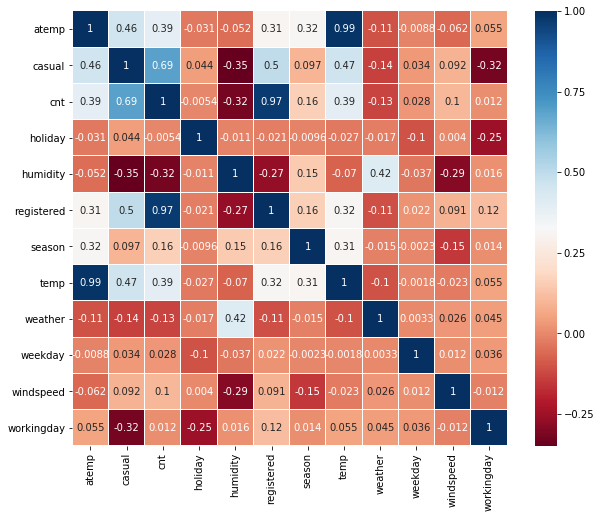

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0,square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

Pada heatmap tersebut terdapat beberapa fitur yang memiliki korelasi tinggi, antara lain : 

1. Fitur cnt dan registered. cnt dan registered memiliki korelasi tinggi. Namun karena hubungan cnt dengan casual dan registered tidak dapat diabaikan. Maka tidak perlu melakukan eliminasi pada salah satu fitur tersebut. 

2. Fitur temp dan atemp. Korelasi keduanya sangat tinggi, sehingga fitur atemp dilakukan eliminasi terhadap fitur atemp dan menyisakan fitur temp. 

In [16]:
#mengeliminasi kolom atemp
data.drop('atemp',axis=1,inplace=True)

# Feature Engineering

### Menambah beberapa fitur yang didapat dari fitur datetime berupa hour, month, day, dan year

In [17]:
data['datetime'] = pd.to_datetime(data['datetime'],format = '%Y-%m-%d %H:%M:%S')

In [18]:
data['hour'] = data['datetime'].dt.hour
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day

### Analisis hubungan register dan casual dengan fitur lain

In [19]:
col_cat=['season','holiday','weekday','workingday','weather','hour','month']

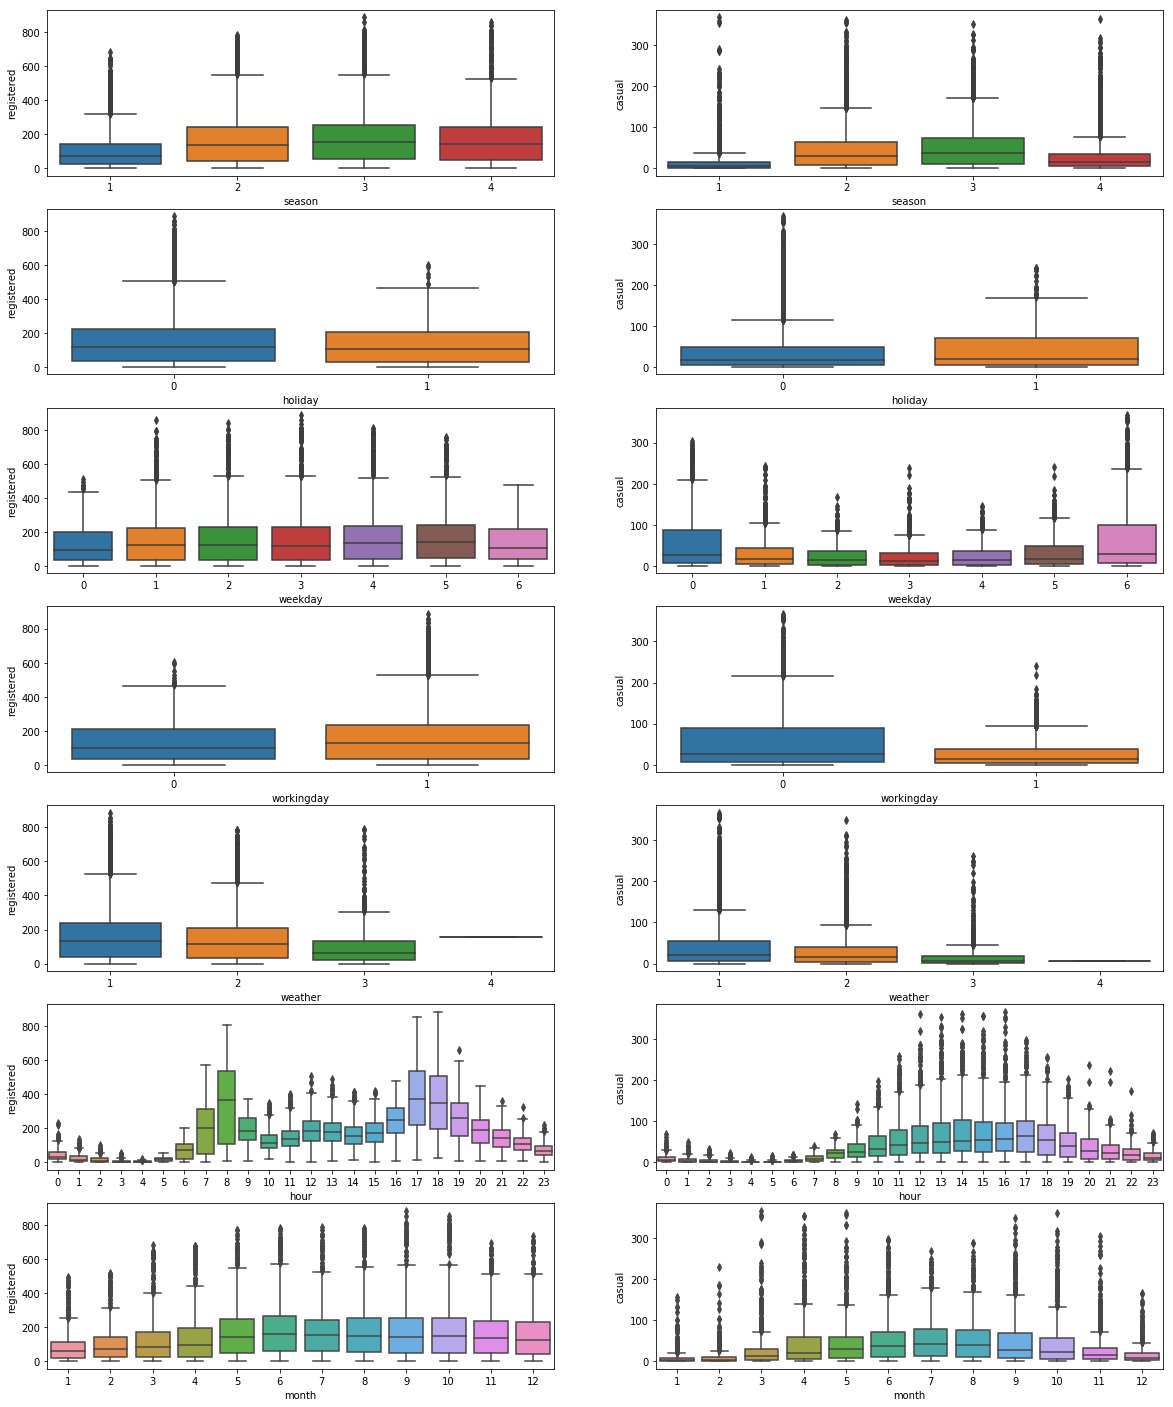

In [20]:
fig, axes = plt.subplots(nrows=7,ncols=2)
fig.set_size_inches(20, 25)
for i,col in enumerate(col_cat):
    sns.boxplot(data=data,y="registered",x=col,orient="v",ax=axes[i][0])
    sns.boxplot(data=data,y="casual",x=col,orient="v",ax=axes[i][1])

Pada grafik hubungan antara hour dan registered. Terdapat waktu waktu tertentu yang sangat tinggi nilai registered-nya, yaitu pada pukul 8, 17, dan 18. Hal tersebut dapat dikarenakan pada waktu waktu tersebut merupakan waktu para pekerja pergi dan pulang ke kantor. Selain itu, para siswa sekolah juga berangkat dan pulang pada waktu waktu tersebut. 

### Memeriksa hubungan hour dan registered pada hari kerja

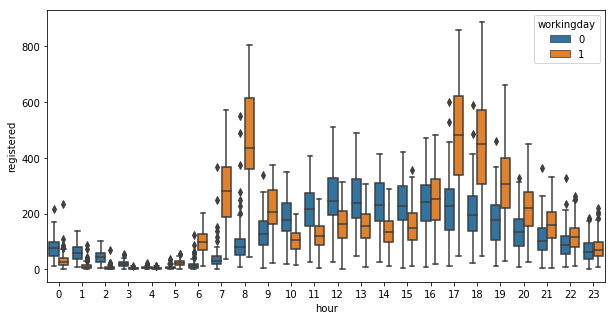

In [21]:
fig, axes = plt.subplots()
fig.set_size_inches(10, 5)
sns.boxplot(data=data,y="registered",x='hour',hue='workingday',orient="v")
plt.show()

Nilai registered meningkat pesat hanya pada saat hari kerja

### Menambah fitur untuk membedakan  jam sibuk dengan waktu lain"

In [22]:
data['rush_hour_registered'] = data[['hour', 'workingday']].apply(lambda x: 
    int((x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18))), axis=1)

### Memeriksa peresebaran data dari beberapa fitur dengan histogram

In [23]:
cols = ['humidity', 'windspeed', 'cnt', 'temp','casual','registered']

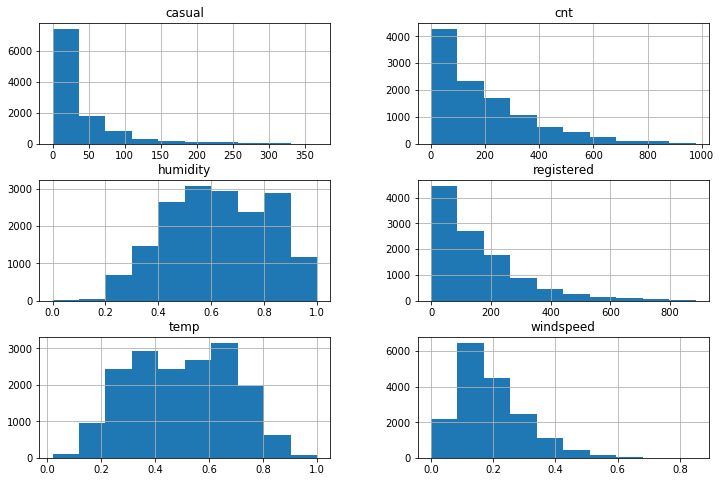

In [24]:
data[cols].hist(figsize=(12,8));

Bentuk histogram dari fitur cnt, casual, registered dan windspeed sangat condong ke kanan. Sehingga perlu dinormalisasi agar model machine learning berjalan dengan baik

In [25]:
ftr=['windspeed','cnt','registered','casual']

In [26]:
for i in ftr:
    data[i]=np.log1p(data[i])

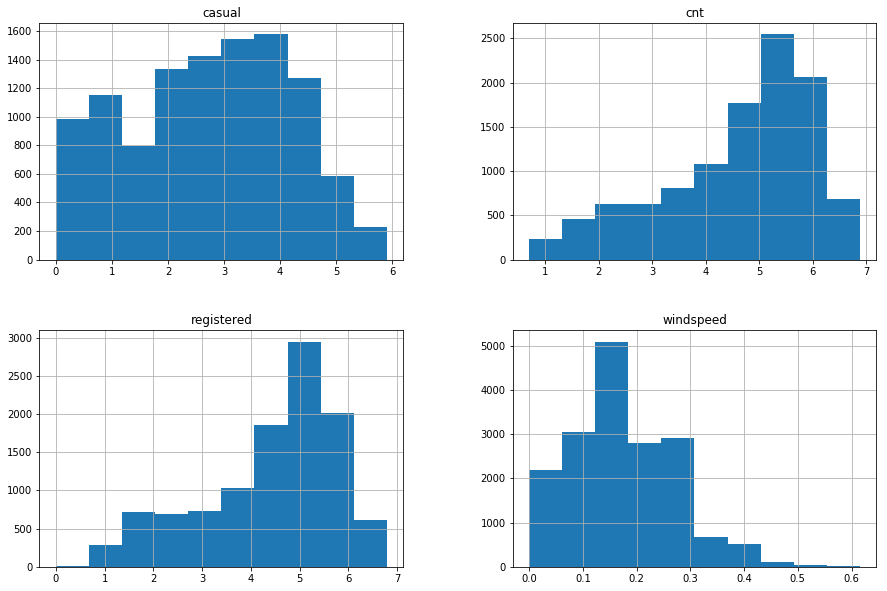

In [27]:
data[ftr].hist(figsize=(15,10));

Bentuk histogram keempat fitur diatas lebih mendekati bentuk distribusi normal

Merubah fitur yang bertipe kategori yaitu fitur weather dengan one hot encoding

In [28]:
data.dtypes

casual                         float64
cnt                            float64
datetime                datetime64[ns]
holiday                          int64
humidity                       float64
registered                     float64
season                           int64
temp                           float64
weather                          int64
weekday                          int64
windspeed                      float64
workingday                       int64
hour                             int64
year                             int64
month                            int64
day                              int64
rush_hour_registered             int64
dtype: object

In [29]:
col_category=['weather']

In [30]:
data[col_category]=data[col_category].astype("category")

In [31]:
data=pd.get_dummies(data)

Analisis beberapa fitur

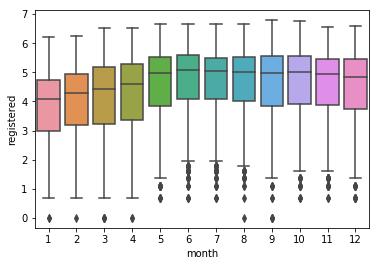

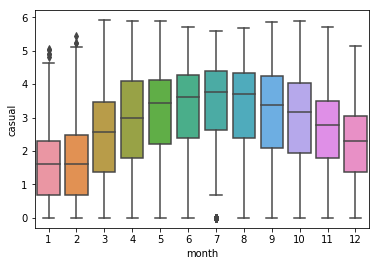

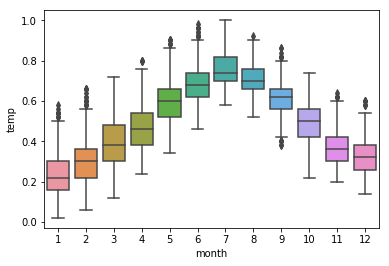

In [32]:
sns.boxplot(data=data,y="registered",x='month',orient="v")
plt.show()
sns.boxplot(data=data,y="casual",x='month',orient="v")
plt.show()
sns.boxplot(data=data,y="temp",x='month',orient="v")
plt.show()

Menurut analisis penulis month tidak berpengaruhi model dikarenakan meningkatnya casual dan register didasarkan menaiknya atau turunya suhu pada bulan tersebut dapat dilihat dari visualisasi diatas

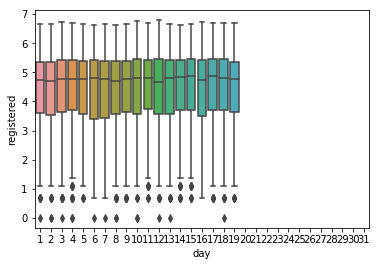

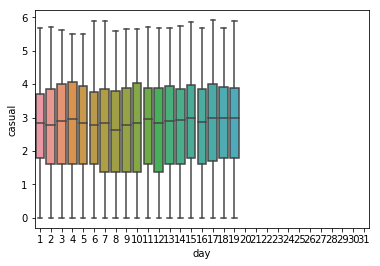

In [33]:
sns.boxplot(data=data,y="registered",x='day',orient="v")
plt.show()
sns.boxplot(data=data,y="casual",x='day',orient="v")
plt.show()

Untuk fitur day tidak digunakan dalam model machine learning dikarenakan data train hanya berisi day 1-19 sedangkan data test hanya berisi day 20-31 dan dapat dilihat pada visualisasi diatas tidak ada tanggal yang sangat mencolok (Sangat jauh meannya dari day yang lain)

In [34]:
data.drop(['day','month'],axis=1,inplace=True)

Pisah Train dan Test

In [35]:
train = data.loc[data['cnt'].isnull()==False]
test = data.loc[data['cnt'].isnull()]

Mengecek fitur yang bagus untuk model dengan permutation importance, dan awalnya mencari model baseline yang cocok dengan train_test_split

In [36]:
train_data, test_data = train_test_split(train,test_size=0.30,random_state=42)

In [37]:
train_X = train_data.drop(['cnt','datetime','registered','casual'],axis=1)
train_y = train_data['cnt']

test_X = test_data.drop(['cnt','datetime','registered','casual'],axis=1)
test_y = test_data['cnt']

In [38]:
def validate(train_X,train_y,test_X,test_y):
    models = [
               ['Lasso: ', Lasso()],
               ['Ridge: ', Ridge()],
               ['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],
               ['RandomForest ',RandomForestRegressor()],
               ['ExtraTreeRegressor :',ExtraTreesRegressor()],
               ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
               ['XGBRegressor: ', xgb.XGBRegressor(n_estimators=1000)],
               ['LGBMRegressor: ', lgb.LGBMRegressor()] 
    ]
    model_data = []
    for name,curr_model in models :
        curr_model_data = {}
        curr_model_data["Nama"] = name
        curr_model.fit(train_X,train_y)
        curr_model_data["RMSLE"] = np.sqrt(mean_squared_log_error(np.expm1(abs(curr_model.predict(test_X))),np.expm1(test_y)))
        model_data.append(curr_model_data)
    return pd.DataFrame(model_data)

In [39]:
validate(train_X,train_y,test_X,test_y)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Nama     RMSLE
0                      Lasso:   1.175387
1                      Ridge:   0.954004
2        KNeighborsRegressor:   0.379142
3                RandomForest   0.339387
4         ExtraTreeRegressor :  0.324089
5  GradientBoostingRegressor:   0.425989
6               XGBRegressor:   0.298290
7              LGBMRegressor:   0.304137

dari tabel diatas dipilih model baseline yaitu XGBRegressor

In [40]:
model=xgb.XGBRegressor(n_estimators=1000)
reg = model
reg.fit(train_X, train_y)
pred = reg.predict(test_X)

D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [41]:
perm = PermutationImportance(reg, random_state=1).fit(train_X, train_y)
eli5.show_weights(perm, feature_names = train_X.columns.tolist(),top=300)

dapat dilihat dari beberapa fitur diatas terdapat beberapa fitur yang tidak terlalu berpengaruh ke model yaitu fitur weather_4, weather_2, dan holiday sehingga bisa dihapus agar memudahkan model machine learning

In [42]:
data.drop(['holiday','weather_2','weather_4'],axis=1,inplace=True)

Pisah Train dan Test

In [43]:
train = data.loc[data['cnt'].isnull()==False]
test = data.loc[data['cnt'].isnull()]

# Validasi

Validasi melakukan train test split dengan pembagian train 0.7 dan test 0.3

In [44]:
train_data, test_data = train_test_split(train,test_size=0.30,random_state=42)

Setelah melalui proses sebelumnya didapat beberapa fitur yang berbeda untuk memprediksi casual dan registerd

## Validasi fitur casual

Untuk memprediksi casual tidak diperlukan fitur rush_hour_registered

In [45]:
train_X = train_data.drop(['rush_hour_registered','datetime','casual','cnt','registered'],axis=1)
train_y = train_data['casual']

test_X = test_data.drop(['rush_hour_registered','datetime','casual','cnt','registered'],axis=1)
test_y = test_data['casual']

In [46]:
validate(train_X,train_y,test_X,test_y)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Nama     RMSLE
0                      Lasso:   1.313457
1                      Ridge:   0.940641
2        KNeighborsRegressor:   0.615042
3                RandomForest   0.531339
4         ExtraTreeRegressor :  0.525282
5  GradientBoostingRegressor:   0.541848
6               XGBRegressor:   0.495982
7              LGBMRegressor:   0.489629

karena akan mengunakan salah satu teknik ensamble yaitu bagging maka dipilih 2 fitur terbaik yaitu XGBRegressor, dan LGBMRegressor

## Validasi fitur registered

In [47]:
train_X = train_data.drop(['datetime','casual','cnt','registered'],axis=1)
train_y = train_data['registered']

test_X = test_data.drop(['datetime','casual','cnt','registered'],axis=1)
test_y = test_data['registered']

In [48]:
validate(train_X,train_y,test_X,test_y)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Nama     RMSLE
0                      Lasso:   1.155093
1                      Ridge:   0.950717
2        KNeighborsRegressor:   0.354871
3                RandomForest   0.325875
4         ExtraTreeRegressor :  0.323563
5  GradientBoostingRegressor:   0.412034
6               XGBRegressor:   0.294943
7              LGBMRegressor:   0.290042

karena akan mengunakan salah satu teknik ensamble yaitu bagging maka dipilih 2 fitur terbaik yaitu XGBRegressor, dan LGBMRegressor

# Modeling

Modeling dengan menggunakan salah satu model ensamble yaitu bagging dengan menggunakan 2 model machine learning yaitu LGBMRegressor dan XGBRegressor

In [49]:
train.columns

Index(['casual', 'cnt', 'datetime', 'humidity', 'registered', 'season', 'temp',
       'weekday', 'windspeed', 'workingday', 'hour', 'year',
       'rush_hour_registered', 'weather_1', 'weather_3'],
      dtype='object')

In [50]:
test_date=test['datetime']
train_X_cas = train.drop(['rush_hour_registered','datetime','casual','cnt','registered'],axis=1)
train_X_registered = train.drop(['datetime','casual','cnt','registered'],axis=1)

train_y_cas = train['casual']
train_y_registered = train['registered']

test_X_cas = test.drop(['rush_hour_registered','datetime','casual','cnt','registered'],axis=1)
test_X_registered = test.drop(['datetime','casual','cnt','registered'],axis=1)

## Parameter Tunning

Tunning yang dilakukan menggunakan GridSearchCV agar hasil lebih akurat

Parameter yang akan ditunning adalah n_estimators dan learning_rate untuk XGBRegressor sedangkan untuk LGBMRegressor parameter yang akan ditunning adalah num_iterations dan learning_rate. Hal ini dikarenakan semua parameter diatas merupakan parameter yang paling berpengaruh banyak, selain itu karena menggunakan GridSearchCV maka diperlukan komputasi yang tinggi sehingga memakan waktu yang cukup lama jika memiliki banyak parameter

In [51]:
xgbr_grid = {
    'n_estimators': [600,800,1000,1200, 1500],
    'learning_rate': [0.1, 0.08,0.05],
}
lgbr_grid = {
    'num_iterations': [50,100,150,200, 250],
    'learning_rate': [0.05,0.07,0.1, 0.08,0.12],
}

## Parameter tuning untuk memprediksi fitur casual

In [52]:
train_X = train_X_cas
train_y = train_y_cas + 2

train_y ditambah 2 dikarenakan scoring neg_mean_squared_log_error tidak bisa digunakan jika prediksi bernilai negatif sehingga perlu dilakukan manipulasi sedikit

In [53]:
xgb1 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb1, xgbr_grid, n_jobs=-1, scoring ='neg_mean_squared_log_error')
xgb_grid.fit(train_X,train_y)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nthread=None, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.08, 0.05],
                         'n_estimators': [600, 800, 1000, 1200, 1500]},
             pre_dispatch='2*n_jobs', refit=True, retur

In [54]:
xgb_grid.best_params_

{'learning_rate': 0.08, 'n_estimators': 600}

In [55]:
lgb1 = lgb.LGBMRegressor()
lgb_grid = GridSearchCV(lgb1, lgbr_grid, n_jobs=-1, scoring ='neg_mean_squared_log_error')
lgb_grid.fit(train_X,train_y)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.07, 0.1, 0.08, 0.12],
                         'num_iterations': [50, 100, 150, 200, 250]},
             pre_dispatc

In [56]:
lgb_grid.best_params_

{'learning_rate': 0.08, 'num_iterations': 100}

## Parameter tuning untuk memprediksi fitur registered

In [57]:
train_X = train_X_registered
train_y = train_y_registered+1

train_y ditambah 1 dikarenakan scoring neg_mean_squared_log_error tidak bisa digunakan jika prediksi bernilai negatif sehingga perlu dilakukan manipulasi sedikit

In [58]:
xgb1 = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb1, xgbr_grid, n_jobs=-1, scoring ='neg_mean_squared_log_error')
xgb_grid.fit(train_X,train_y)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=1,
                                    nthread=None, objective='reg:linear',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.08, 0.05],
                         'n_estimators': [600, 800, 1000, 1200, 1500]},
             pre_dispatch='2*n_jobs', refit=True, retur

In [59]:
xgb_grid.best_params_

{'learning_rate': 0.1, 'n_estimators': 1200}

In [60]:
lgb1 = lgb.LGBMRegressor()
lgb_grid = GridSearchCV(lgb1, lgbr_grid, n_jobs=-1, scoring ='neg_mean_squared_log_error')
lgb_grid.fit(train_X,train_y)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
D:\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.07, 0.1, 0.08, 0.12],
                         'num_iterations': [50, 100, 150, 200, 250]},
             pre_dispatc

In [61]:
lgb_grid.best_params_

{'learning_rate': 0.08, 'num_iterations': 200}

### Validasi proporsi bagging

In [62]:
train_data, test_data = train_test_split(train,test_size=0.30,random_state=42)

### Model yang terpilih

In [63]:
modelCas=[lgb.LGBMRegressor(learning_rate=0.08, num_iterations=100),
       xgb.XGBRegressor(learning_rate=0.08, n_estimators=600)]
modelReg=[lgb.LGBMRegressor(learning_rate=0.08, num_iterations=200),
       xgb.XGBRegressor(learning_rate=0.1, n_estimators=1200)]
pred=[0,0]

Model diatas didapatkan dari hasil tunning parameter sebelumnya

Karena sebelumnya registered dan casual di np.log1p() maka harus dikembalikan ke bentuk awal setelah diprediksi dengan np.expm1()

In [67]:
def predBagging(train,test):
    train_X_cas = train.drop(['rush_hour_registered','datetime','casual','cnt','registered'],axis=1)
    train_X_registered = train.drop(['datetime','casual','cnt','registered'],axis=1)

    train_y_cas = train['casual']
    train_y_registered = train['registered']

    test_X_cas = test.drop(['rush_hour_registered','datetime','casual','cnt','registered'],axis=1)
    test_X_registered = test.drop(['datetime','casual','cnt','registered'],axis=1)

    test_y_cas = test['casual']
    test_y_registered = test['registered']
    
    for i in range(2):
        reg = modelCas[i]
        reg.fit(train_X_cas, train_y_cas)
        pred[i] = reg.predict(test_X_cas)

    cas0 = np.expm1(pred[0])
    cas1 = np.expm1(pred[1])

    for i in range(2):
        reg = modelReg[i]
        reg.fit(train_X_registered, train_y_registered)
        pred[i] = reg.predict(test_X_registered)

    regist0 = np.expm1(pred[0])
    regist1 = np.expm1(pred[1])
    tot0 = abs(cas0 + regist0)
    tot1 = abs(cas1 + regist1)
    return [tot0,tot1]

In [68]:
tot0,tot1=predBagging(train_data,test_data)
model_data = []
i=0.2
while (i<=0.5):
    curr_model_data = {}
    curr_model_data["a"] = round(i,2)
    curr_model_data["b"] = round(1-i,2)
    curr_model_data["RMSLE"] = np.sqrt(mean_squared_log_error(tot0*(i)+tot1*(1-i),np.expm1(test_data['cnt'])))
    model_data.append(curr_model_data)
    i+=0.1
pd.DataFrame(model_data)

D:\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
D:\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE    a    b
0  0.294077  0.2  0.8
1  0.292038  0.3  0.7
2  0.290399  0.4  0.6
3  0.289155  0.5  0.5

In [69]:
tot0,tot1=predBagging(train,test)

D:\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
D:\Anaconda\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [70]:
submit = pd.DataFrame()
submit['datetime'] = test_date
submit['count'] = (tot0*0.5+0.5*tot1)

Melihat data submission

In [71]:
submit

datetime       count
0    2011-01-20 00:00:00   11.132706
1    2011-01-20 01:00:00    4.879286
2    2011-01-20 02:00:00    2.566565
3    2011-01-20 03:00:00    1.722742
4    2011-01-20 04:00:00    1.472027
5    2011-01-20 05:00:00    7.076806
6    2011-01-20 06:00:00   34.265793
7    2011-01-20 07:00:00  102.886446
8    2011-01-20 08:00:00  218.021440
9    2011-01-20 09:00:00  119.654127
10   2011-01-20 10:00:00   54.442261
11   2011-01-20 11:00:00   60.109367
12   2011-01-20 12:00:00   74.480939
13   2011-01-20 13:00:00   71.699057
14   2011-01-20 14:00:00   64.280897
15   2011-01-20 15:00:00   72.312545
16   2011-01-20 16:00:00   92.675458
17   2011-01-20 17:00:00  195.516295
18   2011-01-20 18:00:00  184.805230
19   2011-01-20 19:00:00  112.537349
20   2011-01-20 20:00:00   75.396061
21   2011-01-20 21:00:00   58.726494
22   2011-01-20 22:00:00   39.957136
23   2011-01-20 23:00:00   26.942245
24   2011-01-21 00:00:00   13.899983
25   2011-01-21 01:00:00    7.008430
26   2011-01-21 02:00:00    4.338618
27   2011-01-21 03:00:00    1.345384
28   2011-01-21 04:00:00    1.402220
29   2011-01-21 05:00:00    6.595424
...                  ...         ...
6463 2012-12-30 18:00:00  126.126809
6464 2012-12-30 19:00:00  128.772889
6465 2012-12-30 20:00:00   71.765683
6466 2012-12-30 21:00:00   57.241476
6467 2012-12-30 22:00:00   43.934217
6468 2012-12-30 23:00:00   24.730842
6469 2012-12-31 00:00:00   14.053391
6470 2012-12-31 01:00:00    5.824764
6471 2012-12-31 02:00:00    3.713106
6472 2012-12-31 03:00:00    2.782791
6473 2012-12-31 04:00:00    2.521202
6474 2012-12-31 05:00:00   17.176043
6475 2012-12-31 06:00:00   74.731323
6476 2012-12-31 07:00:00  210.815839
6477 2012-12-31 08:00:00  410.393282
6478 2012-12-31 09:00:00  219.428448
6479 2012-12-31 10:00:00   92.900018
6480 2012-12-31 11:00:00  101.650726
6481 2012-12-31 12:00:00  127.086935
6482 2012-12-31 13:00:00  125.506624
6483 2012-12-31 14:00:00  114.272407
6484 2012-12-31 15:00:00  128.467553
6485 2012-12-31 16:00:00  164.980825
6486 2012-12-31 17:00:00  375.844205
6487 2012-12-31 18:00:00  369.861060
6488 2012-12-31 19:00:00  224.225620
6489 2012-12-31 20:00:00  147.799732
6490 2012-12-31 21:00:00  116.065534
6491 2012-12-31 22:00:00   85.210004
6492 2012-12-31 23:00:00   46.637578

[6493 rows x 2 columns]

Membuat submisi

In [72]:
submit.to_csv('submission.csv',index=False)